# Example of plots

In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.feature_extraction.text import CountVectorizer
import random
import textcl as ts
from nltk.corpus import stopwords
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn import metrics

import nltk
nltk.download('stopwords')

## Prepare input data from the BBC dataset

In [2]:
dataset_path = "./datasets/bbc" # http://mlg.ucd.ie/files/datasets/bbc-fulltext.zip
bbc_dataset = pd.DataFrame([], columns = ['class_name', 'text'])

list_topic_folders = os.listdir("{}/".format(dataset_path))
for topic_folder in list_topic_folders:
    if "txt" not in topic_folder.lower():
        list_of_files = os.listdir("{}/{}".format(dataset_path, topic_folder))
        for file in list_of_files:
            if file.find(".txt") != -1 and file.find("ipynb") == -1:
                with open("{}/{}/{}".format(dataset_path, topic_folder, file), 'rb') as f:
                    text = f.read()
                text = text.decode('windows-1252').replace('\n', ' ')
                bbc_dataset = bbc_dataset.append(pd.DataFrame([[topic_folder, text]], columns = ['class_name', 'text']))
bbc_dataset = bbc_dataset.reset_index(drop=True)

# getting data for business and politics classes
bus_and_pol = bbc_dataset[(bbc_dataset['class_name'] == "business") | (bbc_dataset['class_name'] == "politics")]
df_bus_and_pol_texts = pd.DataFrame(list(bus_and_pol.text.values), columns=['text'])
df_bus_and_pol_texts['y_true'] = 0

# getting 50 random outliers documents from tech class
text_for_outliers = bbc_dataset[bbc_dataset['class_name'] == "tech"]

random.seed(1)
text_for_outliers = text_for_outliers.iloc[random.sample(range(0, len(text_for_outliers)), 50)]
df_outliers = pd.DataFrame(list(text_for_outliers.text.values), columns=['text'])
df_outliers['y_true'] = 1

# add outliers documents nd shuffle
df_test = pd.concat([df_bus_and_pol_texts, df_outliers])
df_test = df_test.sample(frac=1).reset_index(drop=True)

stop = stopwords.words('english')

df_test['text'] = df_test['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_test

,text,y_true
0,Yangtze Electric's profits double Yangtze Elec...,0
1,Lawyer attacks anti-terror laws A senior barri...,0
2,Tsunami debt deal announced Chancellor Gordon ...,0
3,Parties warned 'grey vote' Political parties c...,0
4,Asia quake increases poverty risk Nearly two m...,0
...,...,...
972,UK firm faces Venezuelan land row Venezuelan a...,0
973,Norway upholds 'Napster' ruling A Norwegian st...,1
974,Japan turns beer alternatives Japanese brewers...,0
975,Khodorkovsky quits Yukos shares Jailed tycoon ...,0


In [3]:
# getting bag of words
vectorizer = CountVectorizer()
bag_of_words = vectorizer.fit_transform(df_test['text']).todense()

## TONMF

In [4]:
outlier_matrix,_,_,_ = ts.tonmf(bag_of_words, k=10, alpha=10, beta=0.05)

Text(0.5, 1.0, 'BBC dataset TONMF ROC-curve. K=3, alpha = 1, beta = 0.5')

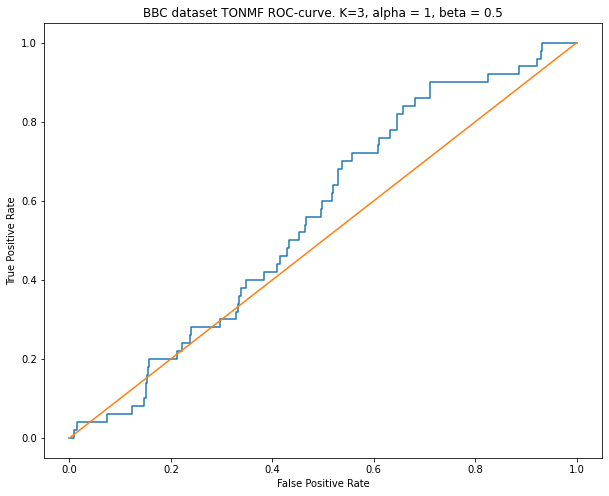

In [5]:
# normalize with l2-normalization
_, y_pred = preprocessing.normalize(outlier_matrix, axis = 1, norm = 'l2', return_norm = True)

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = metrics.roc_curve(list(df_test['y_true'].values), y_pred, pos_label=1)
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('BBC dataset TONMF ROC-curve. K=3, alpha = 1, beta = 0.5')

Text(0.5, 1.0, 'Results of TONMF+L2 (outliers - red, non-outliers - blue)')

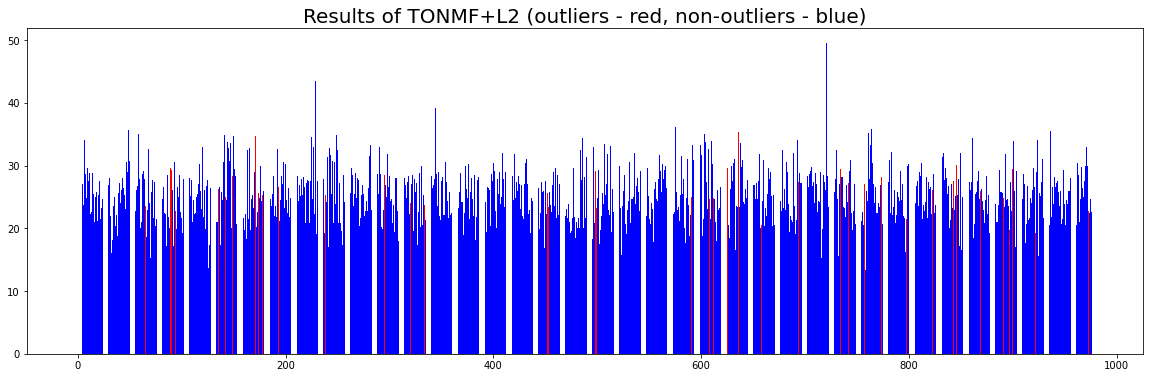

In [6]:
colors_array = np.array(list(df_test['y_true'].values)).astype('str')
colors_array[colors_array == '1'] = 'r'
colors_array[colors_array != 'r'] = 'b'

plt.figure(figsize=(20, 6))
index = range(0, len(y_pred))
plt.bar(index, y_pred, color = colors_array)
plt.title("Results of TONMF+L2 (outliers - red, non-outliers - blue)", size = 20)

## RPCA

In [7]:
outlier_matrix = ts.rpca_implementation(bag_of_words)

Text(0.5, 1.0, 'BBC dataset RPCA ROC-curve')

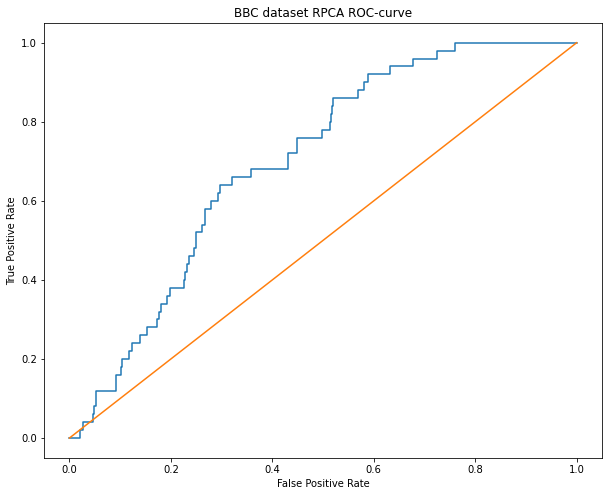

In [8]:
# normalize with l2-normalization
_, y_pred = preprocessing.normalize(outlier_matrix, axis = 1, norm = 'l2', return_norm = True)

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = metrics.roc_curve(list(df_test['y_true'].values), y_pred, pos_label=1)
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('BBC dataset RPCA ROC-curve')

Text(0.5, 1.0, 'Results of RPCA+L2 (outliers - red, non-outliers - blue)')

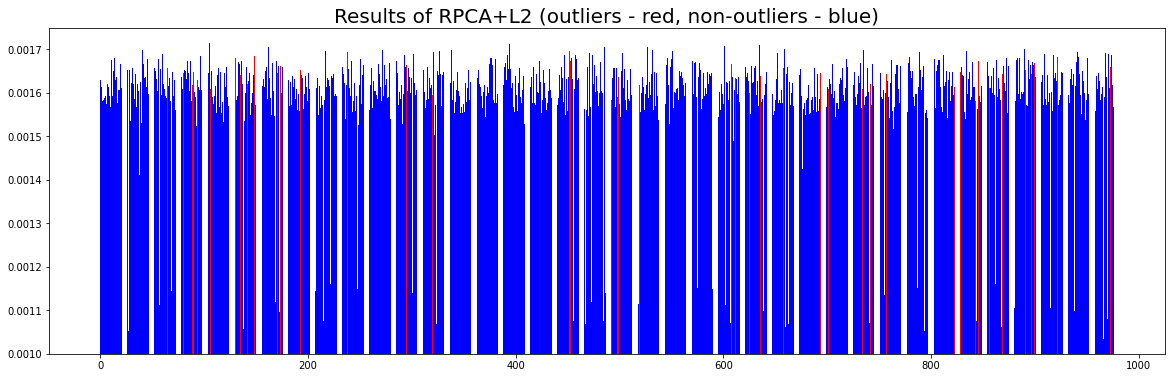

In [9]:
colors_array = np.array(list(df_test['y_true'].values)).astype('str')
colors_array[colors_array == '1'] = 'r'
colors_array[colors_array != 'r'] = 'b'

plt.figure(figsize=(20, 6))
plt.ylim(0.001, 0.00175)
index = range(0, len(y_pred))
plt.bar(index, y_pred, color = colors_array)
plt.title("Results of RPCA+L2 (outliers - red, non-outliers - blue)", size = 20)

## SVD

In [10]:
outlier_matrix = ts.svd(bag_of_words)

Text(0.5, 1.0, 'BBC dataset SVD ROC-curve')

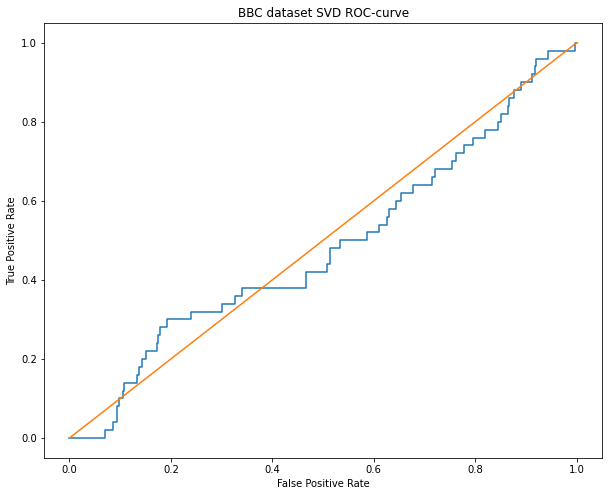

In [11]:
# normalize with l2-normalization
_, y_pred = preprocessing.normalize(outlier_matrix, axis = 1, norm = 'l2', return_norm = True)

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = metrics.roc_curve(list(df_test['y_true'].values), y_pred, pos_label=1)
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('BBC dataset SVD ROC-curve')

Text(0.5, 1.0, 'Results of SVD+L2 (outliers - red, non-outliers - blue)')

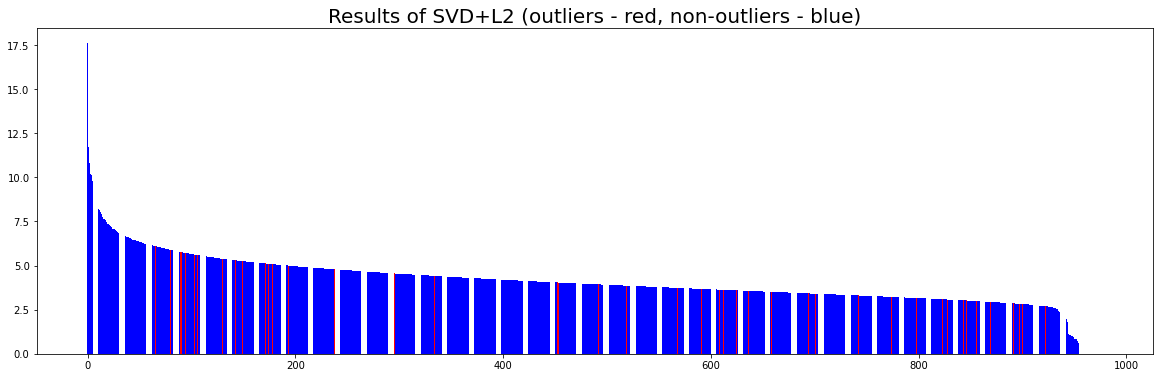

In [12]:
colors_array = np.array(list(df_test['y_true'].values)).astype('str')
colors_array[colors_array == '1'] = 'r'
colors_array[colors_array != 'r'] = 'b'

plt.figure(figsize=(20, 6))
# plt.ylim(0.001, 0.00175)
index = range(0, len(y_pred))
plt.bar(index, y_pred, color = colors_array)
plt.title("Results of SVD+L2 (outliers - red, non-outliers - blue)", size = 20)